In [1]:
import os
import numpy
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
def read_site_csv(csv_filename):
    csv_data = numpy.genfromtxt(csv_filename, delimiter=',', dtype=str)
    csv_v = csv_data[:, 1]
    csv_v = csv_v.astype(float)
    return csv_data[:, 0], csv_v


def mapping_comparison_single(site_obs, site_cal, fig_title='', axis_min=-50, axis_max=650):
    plt.figure(figsize=(8,8))
    
    nan_indices = numpy.isnan(site_obs) | numpy.isnan(site_cal)

    # 删除包含 NaN 值的位置
    x = site_obs[~nan_indices]
    y = site_cal[~nan_indices]
    
    # 绘制1:1参考线
    x_11 = numpy.arange(axis_min, axis_max + 1)
    y_11 = 1 * x_11
    plt.plot(x_11, y_11, color='k', linewidth=1, linestyle='--',)

    # 使用线性回归模型拟合数据
    model = LinearRegression()
    x = x.reshape(-1, 1)
    model.fit(x, y)
    y_pred = model.predict(x)
    xx = numpy.arange(axis_min, axis_max + 0.1, 0.05)
    yy_pred = model.coef_[0] * xx + model.intercept_
    
    # 绘制密度散点图
    xy = numpy.vstack([x.flatten(), y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x_, y_, z = x[idx], y[idx], z[idx]
    z = (z-numpy.min(z))/(numpy.max(z)-numpy.min(z))*100
    plt.scatter(x_, y_, marker='o', c=z, s=8, cmap='turbo')
    
    # 绘制散点图和回归线
#     plt.scatter(x, y, color='b')
    plt.plot(xx, yy_pred, color='red')
    

    # 添加标签
    plt.title(fig_title)
    plt.xlabel('LE observed at site (W/m²)')
    plt.ylabel('ET calculated by PT-JPL (W/m²)')
    
    # 计算散点个数
    num = numpy.count_nonzero(~numpy.isnan(x))

    # 计算回归方程
    equation = f'y = {model.coef_[0]:.2f} * x + {model.intercept_:.2f}'

    # 计算评估指标
    r2 = r2_score(y, y_pred)
    rmse = numpy.sqrt(mean_squared_error(y, y_pred))
    bias = numpy.mean(y_pred - y)
    mae = mean_absolute_error(y, y_pred)

    print('N:', num)
    print('R²:', r2)
    print('RMSE:', rmse)
    print('Bias:', bias)
    print('MAE', mae)

    plt.annotate(f'N: {num:d}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10)
    plt.annotate(equation, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'R²: {r2:.2f}', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.80), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'Bias: {bias:.2f}', xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10)
    plt.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.70), xycoords='axes fraction', fontsize=10)

    # 显示图形
    plt.xlim((axis_min, axis_max))
    plt.ylim((axis_min, axis_max))
#     plt.colorbar(label='density')
    plt.show()


In [3]:
OUTPUT_FOLDER = '/disk2/workspace/20231121'

## CRK

In [31]:
site_output_csv = os.path.join(OUTPUT_FOLDER, 'CRK' + '_PL-JPL_outputs.csv')
datMMS = pd.read_csv(site_output_csv)

In [32]:
site_timelist = numpy.array(datMMS.Time)
site_et_list = numpy.array(datMMS.evapotranspiration).astype(float)

In [33]:
site_obs_le_csv = os.path.join('/disk2/Data/FluxSite4ET/validation', 'CRK' + '_2018_2019_LE.csv')
site_obs_timelist, site_obs_le = read_site_csv(site_obs_le_csv)

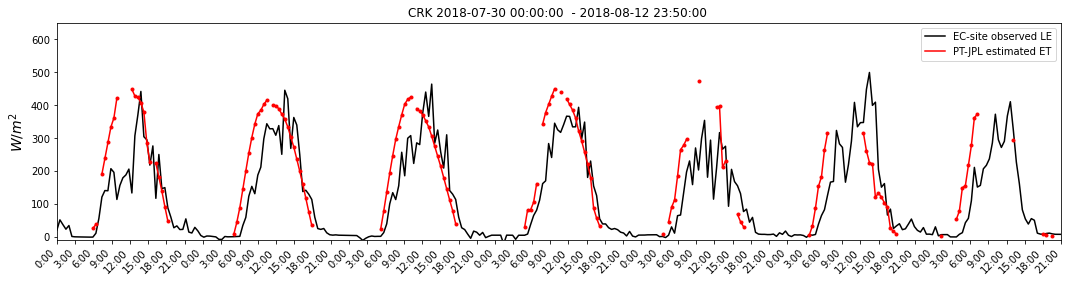

In [34]:
# 30-min
# good 30
week_idx = 30
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]
week_et = numpy.mean(week_et.reshape(-1, 3), axis=1)

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
site_timelist_show = site_timelist_show[::3]

formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
# plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '.', color='black')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='red', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='red')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/6)), formatted_dates[::6], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title(('CRK ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

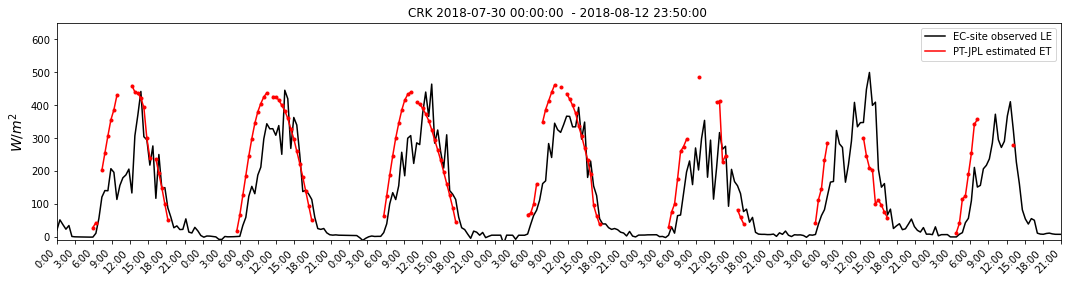

In [19]:
# v0.01

/home/beichen/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


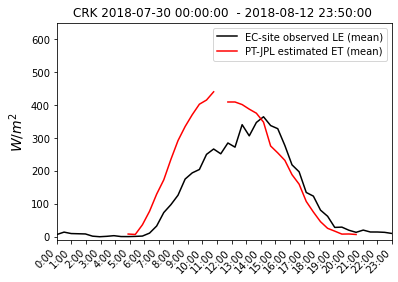

In [9]:
# 30-min
# good 30
week_idx = 30
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]
week_et_30 = numpy.mean(week_et.reshape(-1, 3), axis=1)
week_et_mean = numpy.nanmean(week_et_30.reshape(7, int(week_et_30.shape[0]/7)), axis=0)

week_le_hh = site_obs_le[::3]
week_le_30 = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]
week_le_mean = numpy.nanmean(week_le_30.reshape(7, int(week_le_30.shape[0]/7)), axis=0)

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
site_timelist_show = site_timelist_show[::3]
site_timelist_show = site_timelist_show[:24*2]

formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(6, 4))
plt.plot(numpy.linspace(0, len(week_le_mean), len(week_le_mean)), week_le_mean, '-', color='black', label='EC-site observed LE (mean)')
plt.plot(numpy.linspace(0, len(week_et_mean), len(week_et_mean)), week_et_mean, '-', color='red', label='PT-JPL estimated ET (mean)')
plt.xticks(numpy.linspace(0, len(formatted_dates), int(len(formatted_dates)/2)), formatted_dates[::2], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et_mean))
plt.ylim((-10,650))
plt.title(('CRK ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

/home/beichen/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


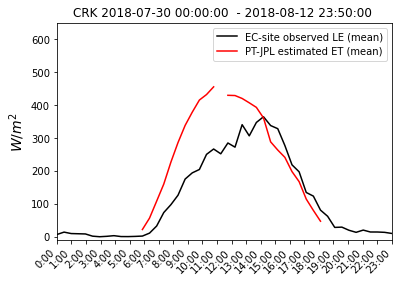

In [48]:
# v0.01

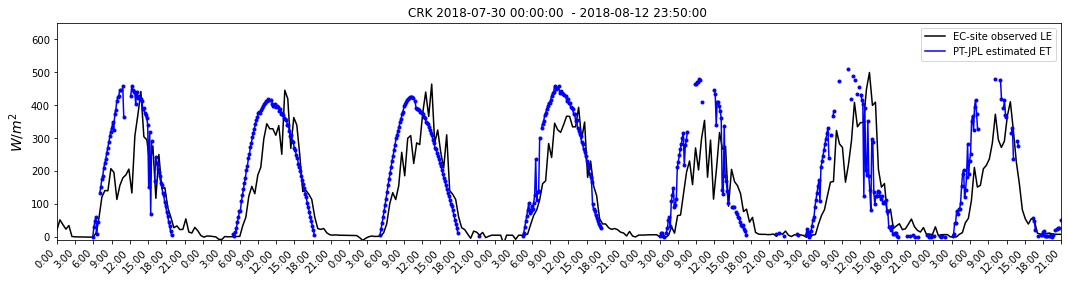

In [10]:
# good 30
week_idx = 30
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title(('CRK ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

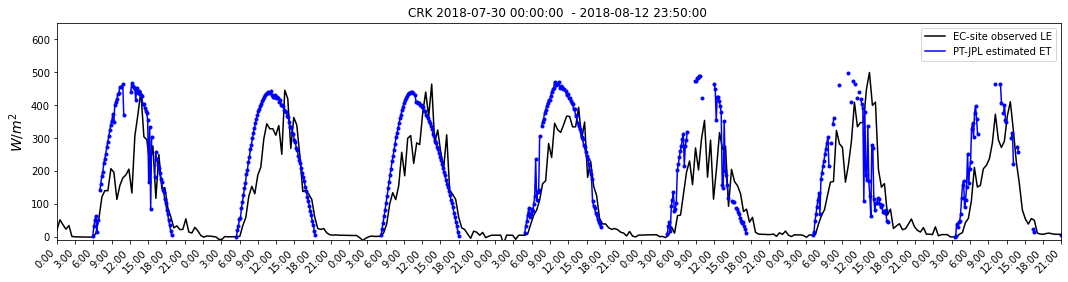

In [7]:
# v0.01

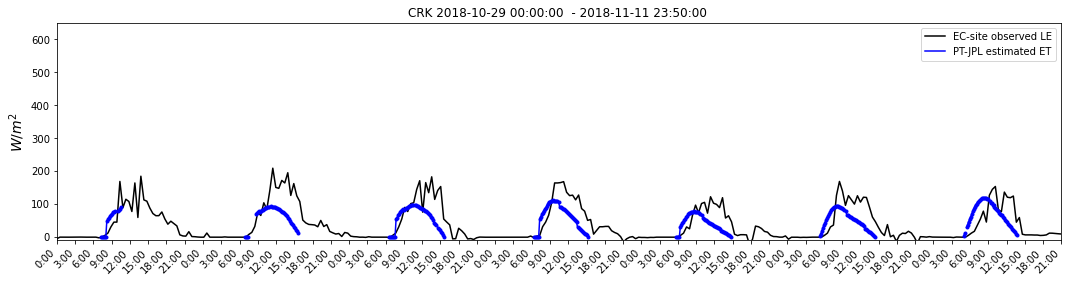

In [11]:
# good 30
week_idx = 43
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title(('CRK ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

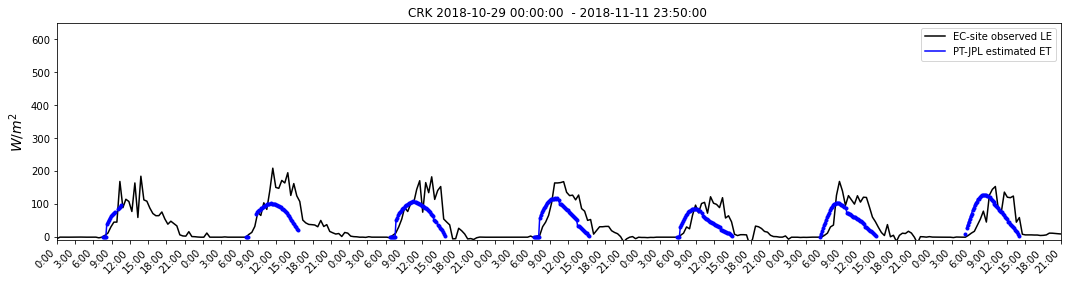

In [8]:
# v0.01

N: 7506
R²: 0.4255549584267855
RMSE: 91.93772934645799
Bias: 9.208845901244678e-15
MAE 68.56934735412355


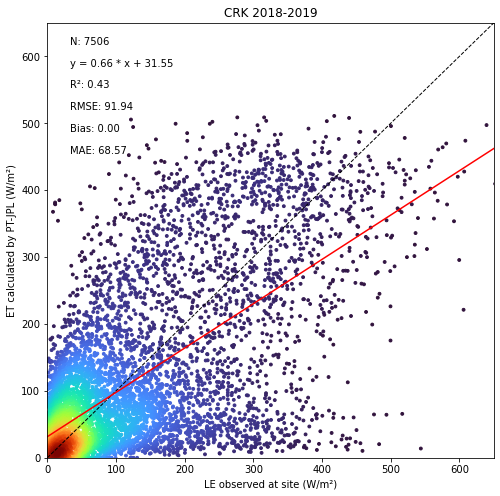

In [39]:
# mean ET every 30 min
site_obs_0 = numpy.copy(site_obs_le)
site_obs_0[site_obs_0<0]=numpy.NaN
site_obs_30 = site_obs_0[::3]
site_et_30 = numpy.mean(site_et_list.reshape(-1, 3), axis=1)
mapping_comparison_single(site_obs_30, site_et_30, 'CRK' + ' 2018-2019', axis_min=0, axis_max=650)

N: 8824
R²: 0.4939318472036863
RMSE: 94.2408168052604
Bias: -1.3193032845300863e-14
MAE 68.8958818550866


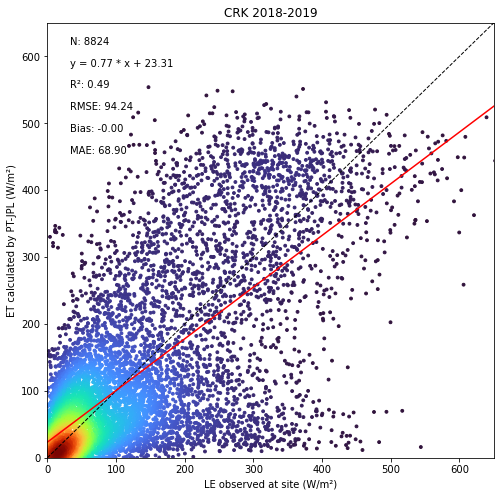

In [15]:
# v0.01

## GCK

In [13]:
site_output_csv = os.path.join(OUTPUT_FOLDER, 'GCK' + '_PL-JPL_outputs.csv')
datMMS = pd.read_csv(site_output_csv)

In [14]:
site_timelist = numpy.array(datMMS.Time)
site_et_list = numpy.array(datMMS.evapotranspiration).astype(float)

In [15]:
site_obs_le_csv = os.path.join('/disk2/Data/FluxSite4ET/validation', 'GCK' + '_2018_2019_LE.csv')
site_obs_timelist, site_obs_le = read_site_csv(site_obs_le_csv)

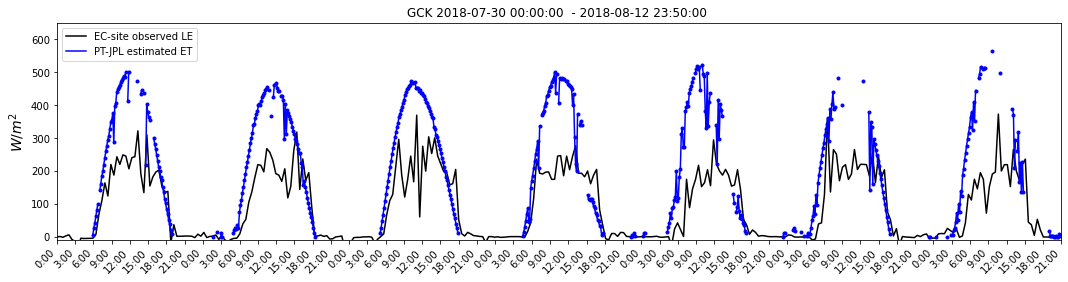

In [16]:
# good 30
week_idx = 30
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title(('GCK ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

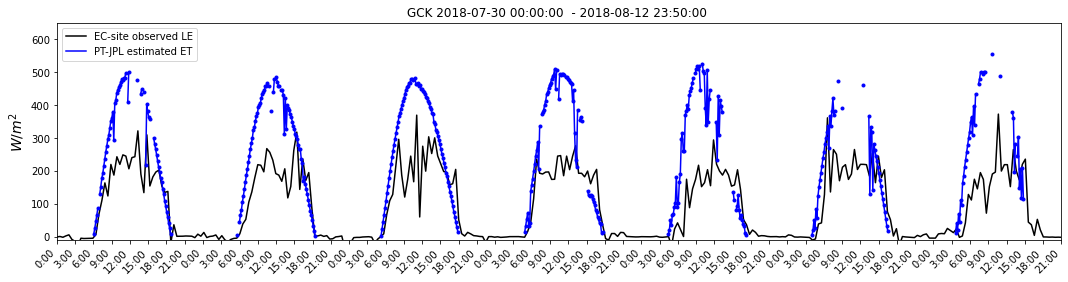

In [19]:
# v0.01

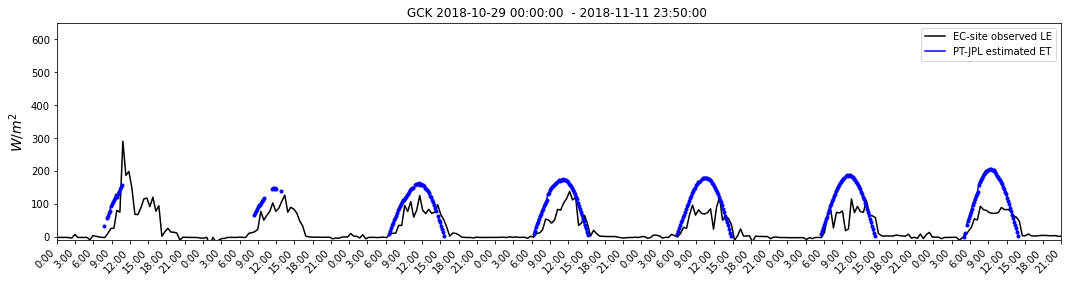

In [17]:
# good 30
week_idx = 43
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title(('GCK ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

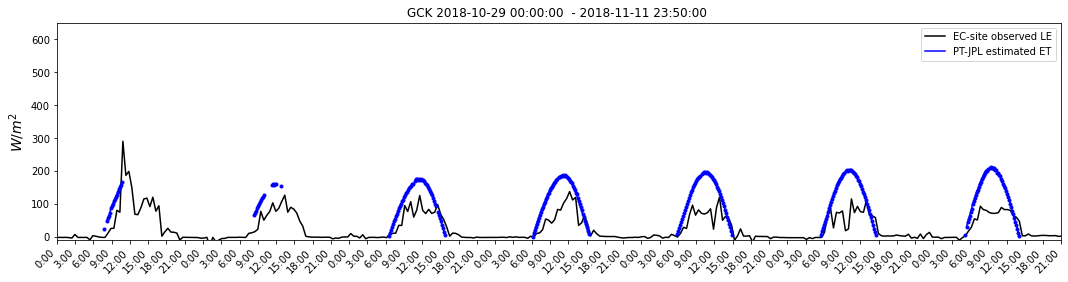

In [20]:
# v0.01

N: 8509
R²: 0.578427332964693
RMSE: 97.99251865667566
Bias: -2.0735923392166893e-14
MAE 72.3574757532305


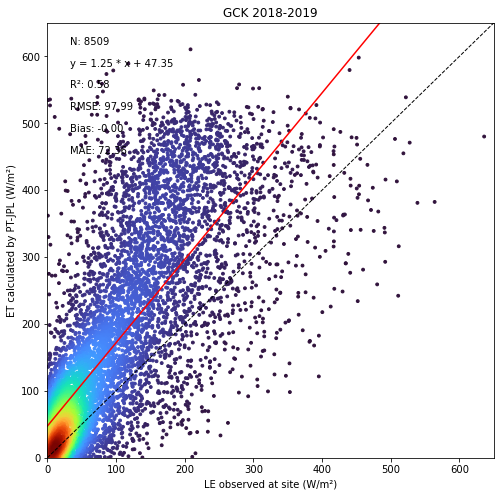

In [18]:
site_obs_0 = numpy.copy(site_obs_le)
site_obs_0[site_obs_0<0]=numpy.NaN
mapping_comparison_single(site_obs_0, site_et_list, 'GCK' + ' 2018-2019', axis_min=0, axis_max=650)

N: 8054
R²: 0.5720220290545706
RMSE: 101.92671092165206
Bias: -3.613587094205824e-15
MAE 75.55815965433447


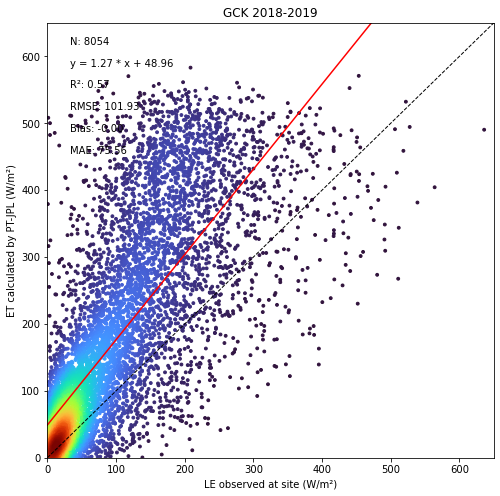

In [21]:
# v0.01

## GDK

In [19]:
site_name = 'GDK'
site_output_csv = os.path.join(OUTPUT_FOLDER, site_name + '_PL-JPL_outputs.csv')
datMMS = pd.read_csv(site_output_csv)

site_timelist = numpy.array(datMMS.Time)
site_et_list = numpy.array(datMMS.evapotranspiration).astype(float)

site_obs_le_csv = os.path.join('/disk2/Data/FluxSite4ET/validation', site_name + '_2018_2019_LE.csv')
site_obs_timelist, site_obs_le = read_site_csv(site_obs_le_csv)

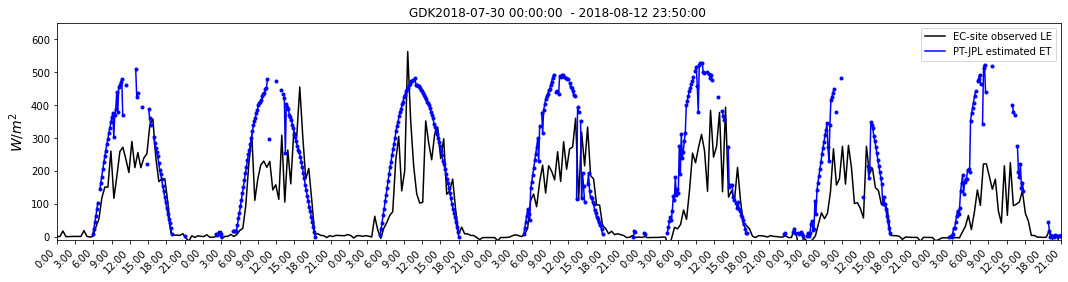

In [20]:
# good 30
week_idx = 30
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title((site_name + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

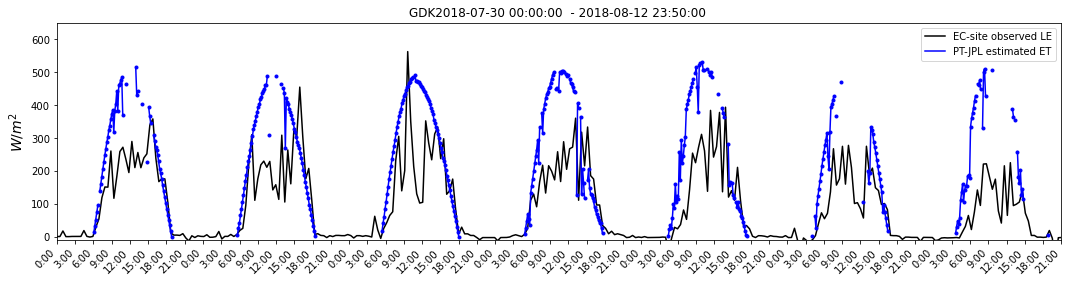

In [23]:
# v0.01

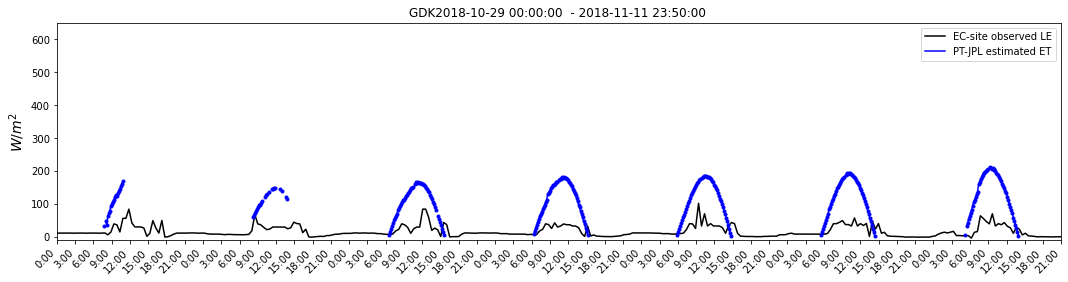

In [21]:
# good 30
week_idx = 43
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title((site_name + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

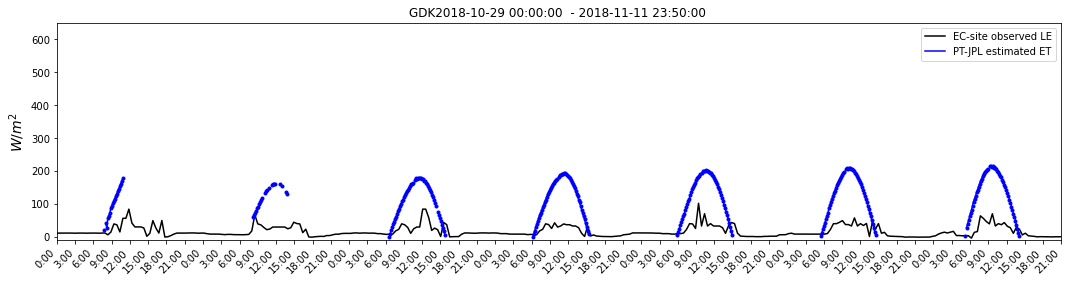

In [24]:
# v0.01

N: 8510
R²: 0.5863593504350805
RMSE: 99.00875575471657
Bias: 2.0947234024382366e-14
MAE 75.9687179923414


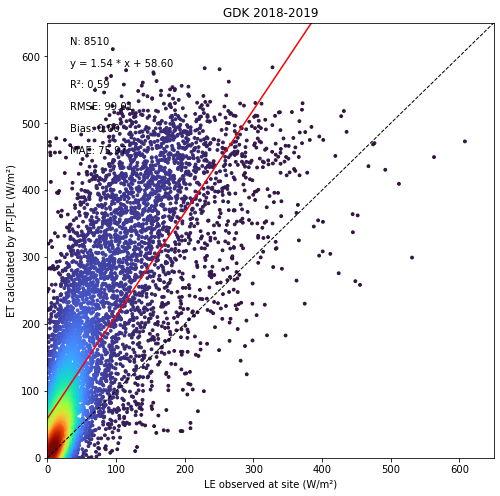

In [22]:
site_obs_0 = numpy.copy(site_obs_le)
site_obs_0[site_obs_0<0]=numpy.NaN
mapping_comparison_single(site_obs_0, site_et_list, site_name + ' 2018-2019', axis_min=0, axis_max=650)

N: 7902
R²: 0.5740513394181019
RMSE: 104.05619095230915
Bias: 2.900438684469475e-14
MAE 80.76966193440242


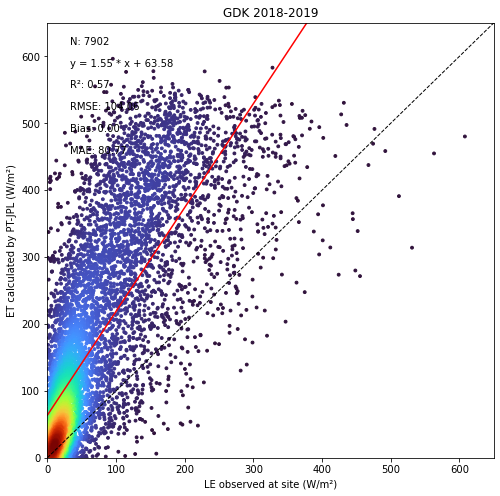

In [25]:
# v0.01

## TKY

In [23]:
site_name = 'TKY'
site_output_csv = os.path.join(OUTPUT_FOLDER, site_name + '_PL-JPL_outputs.csv')
datMMS = pd.read_csv(site_output_csv)

site_timelist = numpy.array(datMMS.Time)
site_et_list = numpy.array(datMMS.evapotranspiration).astype(float)

site_obs_le_csv = os.path.join('/disk2/Data/FluxSite4ET/validation', site_name + '_2018_2019_LE.csv')
site_obs_timelist, site_obs_le = read_site_csv(site_obs_le_csv)

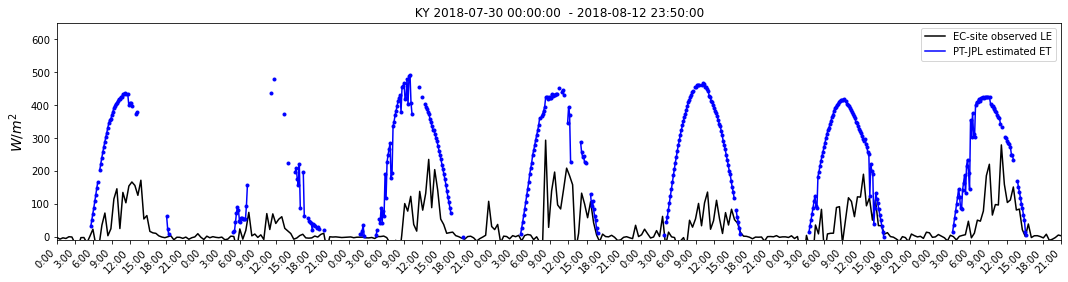

In [24]:
# good 30
week_idx = 30
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title((site_name + ' ' + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

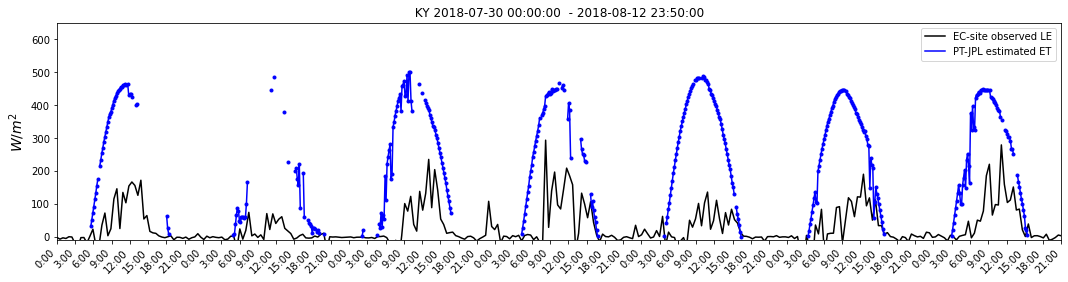

In [27]:
# v0.01

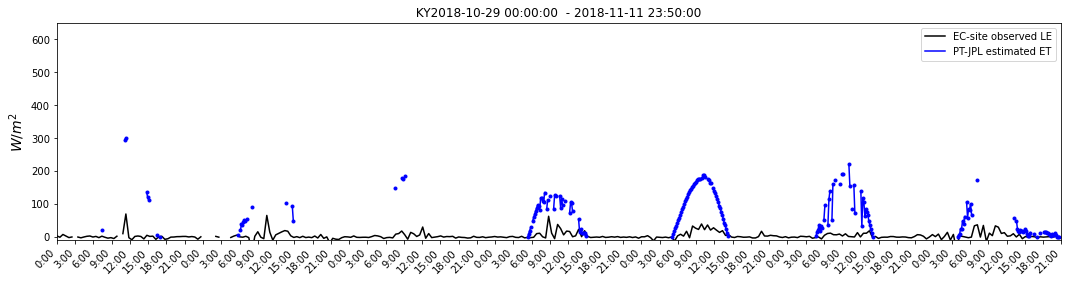

In [26]:
# good 30
week_idx = 43
week_et = site_et_list[7*24*6*week_idx:7*24*6*(week_idx+1)]

week_le_hh = site_obs_le[::3]
week_le = week_le_hh[7*24*2*week_idx:7*24*2*(week_idx+1)]

site_timelist_show = site_timelist[7*24*6*week_idx:7*24*6*(week_idx+1)]
formatted_dates = []
for date_string in site_timelist_show:
    dt_object = datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%SZ")
    formatted_date = dt_object.strftime("%-H:%M")
    formatted_dates.append(formatted_date)

plt.figure(figsize=(18, 4))
plt.plot(numpy.linspace(0, len(week_et), len(week_le)), week_le, '-', color='black', label='EC-site observed LE')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '-', color='blue', label='PT-JPL estimated ET')
plt.plot(numpy.linspace(0, len(week_et), len(week_et)), week_et, '.', color='blue')
plt.xticks(numpy.linspace(0, len(week_et), int(len(week_et)/18)), formatted_dates[::18], rotation=45, ha='right')
plt.ylabel(r'$W/m^2$', fontsize=14)
plt.xlim(0,len(week_et))
plt.ylim((-10,650))
plt.title((site_name + site_timelist[7*24*6*week_idx] + ' - ' + site_timelist[7*24*6*(week_idx+2)-1]).replace('T',' ').replace('Z',' '))
plt.legend()

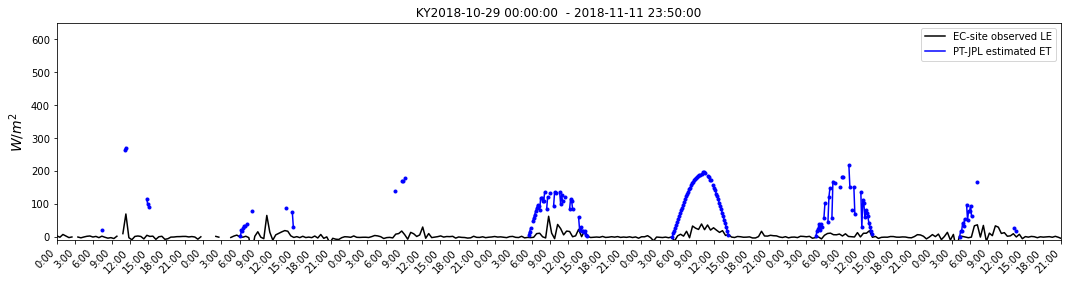

In [28]:
# v0.01

N: 2356
R²: 0.2831414420180549
RMSE: 128.9150962937565
Bias: -4.6324008579266296e-14
MAE 104.14600002648385


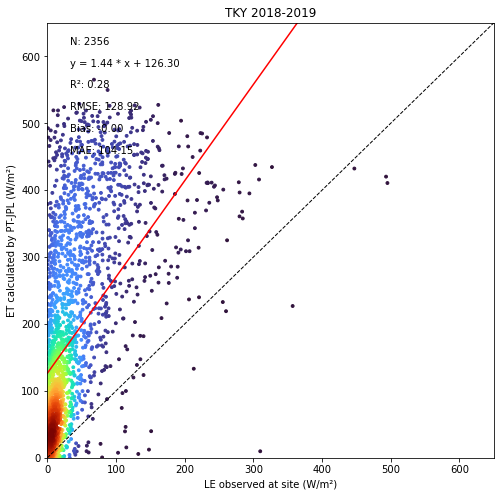

In [27]:
site_obs_0 = numpy.copy(site_obs_le)
site_obs_0[site_obs_0<0]=numpy.NaN
mapping_comparison_single(site_obs_0, site_et_list, site_name + ' 2018-2019', axis_min=0, axis_max=650)

N: 2157
R²: 0.28212475632556067
RMSE: 132.32833366020995
Bias: 1.0119551619170272e-14
MAE 107.88162654635958


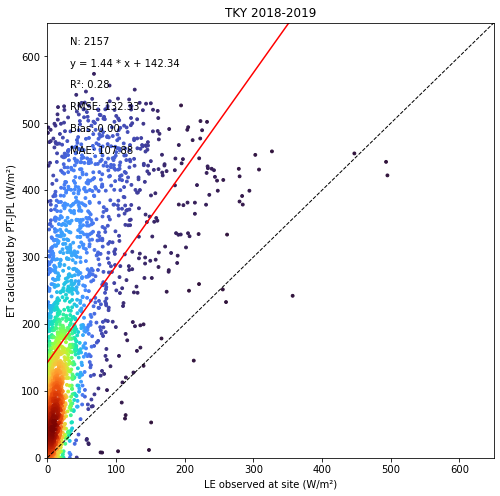

In [30]:
# v0.01